In [1]:
"""pip install scikit-optimize
pip install optuna
pip install fitter"""

'pip install scikit-optimize\npip install optuna\npip install fitter'

In [2]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
from tabulate import tabulate
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
# ==============================================================================================================================================================

#Preprocesado y Modelado
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.ensemble import RandomForestClassifier

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varios
# ==============================================================================================================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions
# Configuración matplotlib
# ==============================================================================================================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================================================================================================
import warnings
warnings.filterwarnings('ignore')

# Objetivo

Obtener un modelo capaz de predecir si se rechaza o no un canal de res cárnico

In [3]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [4]:
data1 = data.drop(["PBA", "CF", "CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO"], axis=1)

In [5]:
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


### Variable de Respuesta 

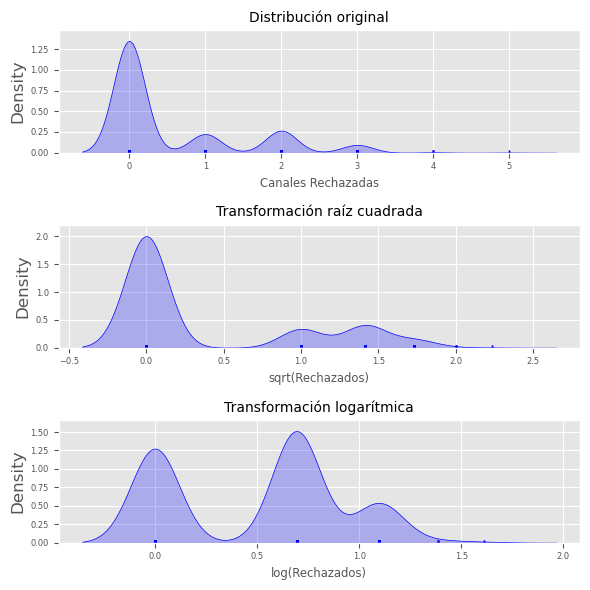

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    data1.Rechazados,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    data1.Rechazados,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Canales Rechazadas', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.sqrt(data1.Rechazados),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(data1.Rechazados),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Rechazados)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(data1.Rechazados),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(data1.Rechazados),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Rechazados)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

### Ditribución de Probabilidad

In [7]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(data1.Rechazados, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

Fitting 9 distributions: 100%|██████████| 9/9 [00:01<00:00,  5.31it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,118.627433,1281.607504,-5300.091957,inf,0.694282,0.000000e+00
exponpow,126.073559,585.308791,-5183.571905,inf,0.694357,0.000000e+00
beta,152.240519,437.963608,-4815.042027,inf,0.694357,0.000000e+00
chi2,165.332892,459.363260,-4664.695253,inf,0.694357,0.000000e+00
expon,175.167721,790.640503,-4561.655633,inf,0.694357,0.000000e+00
powerlaw,186.088242,386.602081,-4438.345590,inf,0.694357,0.000000e+00
logistic,197.286140,800.580710,-4334.059515,inf,0.372468,7.643201e-239
norm,198.993160,852.109693,-4317.569848,inf,0.417928,2.322199e-303
cauchy,206.734080,9137.146821,-4244.526105,inf,0.351491,6.050174e-212


### Correlación variables numéricas

De archivo ejecutadon con regresión se evidenció una correlación entre dos variables independientes, por lo que procederemos a eñliminar a una, la variable Ocupación

In [8]:
data1 = data1.drop(["Ocupacion"],axis=1)

### Variabes cualitativas

Eliminamos los registros de PBA2 solo quedandonos con PBA1 

In [9]:
data1 = data1.loc[data1["TIPO_CAP_CF"] != "PBA2", :]

In [10]:
data1.loc[data1["Rechazados"] > 0, "Rechazados"] = 1
print(data1.Rechazados.value_counts().sort_index())

0    1259
1     583
Name: Rechazados, dtype: int64


In [11]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('Rechazados', axis = 'columns'),
                                        data1['Rechazados'],
                                        train_size   = 0.67,
                                        random_state = 1234,
                                        
                                        shuffle      = True
                                    )

In [12]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())
print("-----------------------")
print("-----------------------")
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de entrenamento
-----------------------
count    1234.000000
mean        0.321718
std         0.467325
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Rechazados, dtype: float64
-----------------------
-----------------------
Partición de test
-----------------------
count    608.000000
mean       0.305921
std        0.461176
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Rechazados, dtype: float64


## Modelo

### Random Forest

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestClassifier(n_estimators=10))])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 100, 1000, 10000],
    'modelo__max_features': ['sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
16,10000,sqrt,None,0.695306,0.02866,1.0,0.0


In [14]:
# Error de test del modelo final
# ==============================================================================
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
rf_model = grid.best_estimator_
predicciones3 = rf_model.predict(X = X_test)
Accuracy_rf= accuracy_score(y_true  = y_test, y_pred  = predicciones3)
print(f"Accuracy: {Accuracy_rf}")
RMSE_rf = mean_squared_error(y_true  = y_test, y_pred  = predicciones3, squared = False)
print(f"RMSE: {RMSE_rf}")

Accuracy: 0.7549342105263158
RMSE: 0.49504119977400285


### Gradient Boosting Trees

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__loss': ['log_loss', 'deviance', 'exponential'],
    'modelo__n_estimators': [50, 100, 1000, 5000],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.1, 0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__subsample,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,param_modelo__loss,mean_test_score,std_test_score,mean_train_score,std_train_score
12,1,100,sqrt,5,exponential,-0.548643,0.021284,-0.190024,0.017008


In [16]:
gbt_model = grid.best_estimator_
predicciones4 = gbt_model.predict(X = X_test)

Accuracy_gbt= accuracy_score(y_true  = y_test, y_pred  = predicciones4)
print(f"Accuracy: {Accuracy_gbt}")
RMSE_gbt = mean_squared_error(y_true  = y_test, y_pred  = predicciones4, squared = False)
print(f"RMSE: {RMSE_gbt}")

Accuracy: 0.743421052631579
RMSE: 0.5065362251294778


### Árboles de decisión

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', DecisionTreeClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__criterion': ['gini', 'entropy', 'log_loss'],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__min_samples_split': [1, 2, 10, 500],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 10000],
    'modelo__max_leaf_nodes'   : [1, 10, 20, 100, 10000],
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train, modelo__sample_weight = X_train["Ti1"])

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__min_samples_split,param_modelo__max_leaf_nodes,param_modelo__max_features,param_modelo__max_depth,param_modelo__criterion,mean_test_score,std_test_score,mean_train_score,std_train_score
1,500,10,auto,10000,gini,-0.567564,0.019944,-0.566401,0.005465


In [18]:
dtree_model = grid.best_estimator_
predicciones5 = gbt_model.predict(X = X_test)

Accuracy_dtree= accuracy_score(y_true  = y_test, y_pred  = predicciones5)
print(f"Accuracy: {Accuracy_dtree}")
RMSE_dtree = mean_squared_error(y_true  = y_test, y_pred  = predicciones5, squared = False)
print(f"RMSE: {RMSE_dtree}")

Accuracy: 0.743421052631579
RMSE: 0.5065362251294778


## Stacking

In [28]:
from sklearn.ensemble import StackingClassifier

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestClassifier(
                                         n_estimators = 10000,
                                         max_features = 'sqrt',
                                         max_depth    = None
                                        )
                     )])

pipe_gbt = Pipeline([('preprocessing', preprocessor),
                     ('Gradient_Boosting_Trees', GradientBoostingClassifier(
                                         subsample = 1,                 
                                         n_estimators = 100,
                                         max_features = 'sqrt',
                                         max_depth    = 5,
                                         loss= 'exponential'
                                        )
                     )])

pipe_dtree = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', DecisionTreeClassifier(
                                         min_samples_split = 500,                 
                                         max_leaf_nodes = 10,
                                         max_features = 'auto',
                                         max_depth    = 10000,
                                         criterion = 'gini'
                                        )
                     )])

In [29]:
# Definición y entrenamiento del StackingClassifier
# ==============================================================================
from sklearn.linear_model import LogisticRegression
estimators = [('random_forest', pipe_rf),
              ('Gradient_Boosting_Trees', pipe_gbt),
              ('Decision_Tree', pipe_dtree),
              ]

stacking_cla= StackingClassifier(estimators=estimators,
                                       final_estimator=LogisticRegression())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_cla.fit(X = X_train, y = y_train)

In [30]:
stacking_model = stacking_cla
predicciones7 = stacking_model.predict(X = X_test)

Accuracy_stacking= accuracy_score(y_true  = y_test, y_pred  = predicciones7)
print(f"Accuracy: {Accuracy_stacking}")
RMSE_stacking = mean_squared_error(y_true  = y_test, y_pred  = predicciones7, squared = False)
print(f"RMSE: {RMSE_stacking}")

Accuracy: 0.75
RMSE: 0.5


Text(0.5, 0, 'Test accuracy')

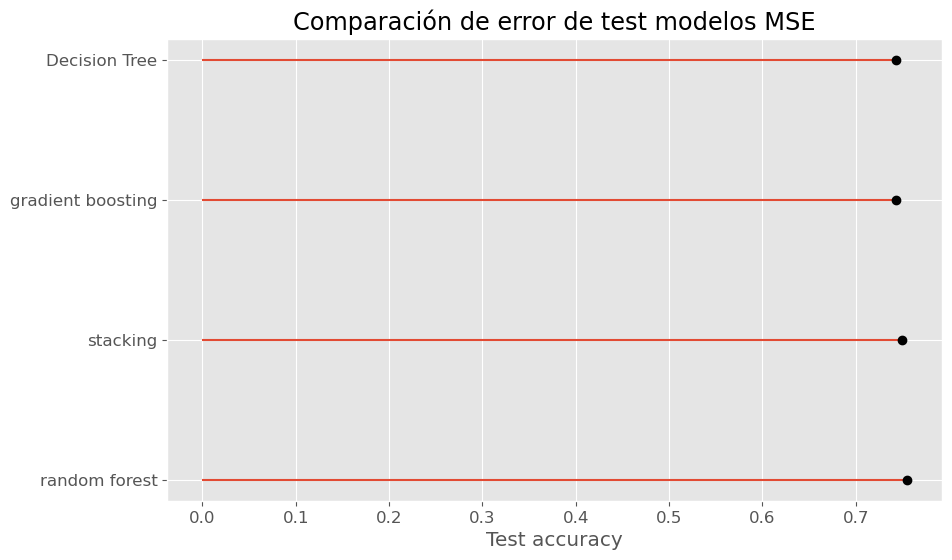

In [31]:
error_modelos = pd.DataFrame({'modelo': ['random forest', 'gradient boosting',"Decision Tree",'stacking'],
                              'Accuracy': [Accuracy_rf, Accuracy_gbt, Accuracy_dtree,  Accuracy_stacking]})
error_modelos = error_modelos.sort_values('Accuracy', ascending=False)


plt.figure(figsize=(10, 6))
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.Accuracy)
plt.plot(error_modelos.Accuracy, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación de error de test modelos MSE')
plt.xlabel('Test accuracy')



# Metricas Para Random Forest


<AxesSubplot:>

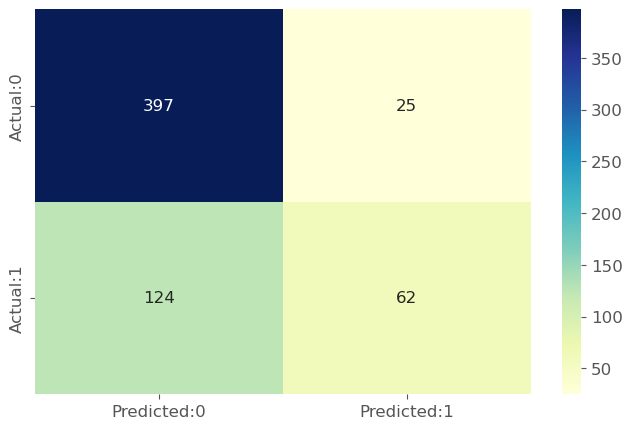

In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,predicciones3)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [37]:
VN = cm[1,1]
VP = cm[0,0]
FN = cm[1,0]
FP = cm[0,1] 
Exactitud = (VP+VN)/(VP+VN+FP+FN) #Acurracy
Sencibilidad = VP/float(VP+FN)
Especificidad = VN/float(VN+FP)

print(f'Exactitud :{100*Exactitud}%','\n',
f'Sencibilidad :{100*Sencibilidad}%','\n',
f'Especificidad :{100*Especificidad}%','\n') 

Exactitud :75.49342105263158% 
 Sencibilidad :76.1996161228407% 
 Especificidad :71.26436781609196% 



In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test,  predicciones3))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       422
           1       0.71      0.33      0.45       186

    accuracy                           0.75       608
   macro avg       0.74      0.64      0.65       608
weighted avg       0.75      0.75      0.72       608



## Predicción de Probabilidad

In [46]:
# Predicción de probabilidades
# ==============================================================================
predicciones = rf_model.predict_proba(X = X_test)
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(5)

,0,1,clasificacion_default_0.5
0,0.5627,0.4373,0
1,0.7608,0.2392,0
2,0.8625,0.1375,0
3,0.8699,0.1301,0
4,0.6912,0.3088,0


#### Modificando el umbral de probabilidad para la clasificación

In [49]:
#from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import binarize


Umbral = pd.DataFrame(np.zeros((9,4)), columns=["Umbral", "Sensibilidad", "Especificidad", "Exactitud"])
for i in range(1,10):
    cm2=0
    y_pred2 = np.where(df_predicciones['1'] > (i/10), 1, 0)
    cm2=confusion_matrix(y_test,y_pred2)
    VN2 = cm2[1,1]
    VP2 = cm2[0,0]
    FN2 = cm2[1,0]
    FP2 = cm2[0,1] 
    Exactitud2 = (VP2+VN2)/(VP2+VN2+FP2+FN2) #Acurracy
    Sencibilidad2 = VP2/float(VP2+FN2)
    Especificidad2 = VN2/float(VN2+FP2)
    Umbral.loc[i-1,'Umbral'] = i/10
    Umbral.loc[i-1,'Sensibilidad'] = Sencibilidad2 
    Umbral.loc[i-1,'Especificidad'] = Especificidad2 
    Umbral.loc[i-1,'Exactitud'] = Exactitud2
Umbral

,Umbral,Sensibilidad,Especificidad,Exactitud
0,0.1,1.000000,0.313659,0.330592
1,0.2,0.900552,0.393443,0.544408
2,0.3,0.853896,0.470000,0.664474
3,0.4,0.804296,0.550265,0.725329
4,0.5,0.761996,0.712644,0.754934
5,0.6,0.710884,0.800000,0.713816
6,0.7,0.695868,0.666667,0.695724
7,0.8,0.696370,1.000000,0.697368
8,0.9,0.694079,NaN,0.694079


## Importancia de predictores
Importancia por permutación

In [57]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = rf_model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
7,0.329173,0.008551,Ti2
11,0.188474,0.011577,pH_Requisito
6,0.164650,0.010902,Temp3
12,0.129579,0.008072,Tamin
10,0.119518,0.011832,PPPCF
3,0.109133,0.009132,Temp2
4,0.106093,0.009463,Franja2
2,0.095368,0.011963,Franja1
0,0.093378,0.005707,Dia_Semana
1,0.090244,0.011039,Temp1


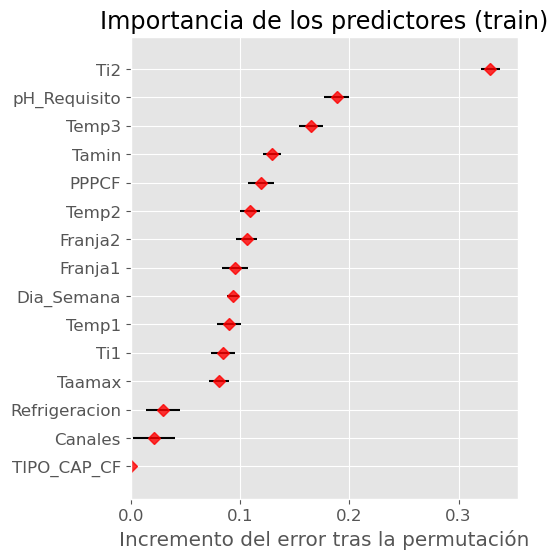

In [58]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

# Metricas Para el Stacking


<AxesSubplot:>

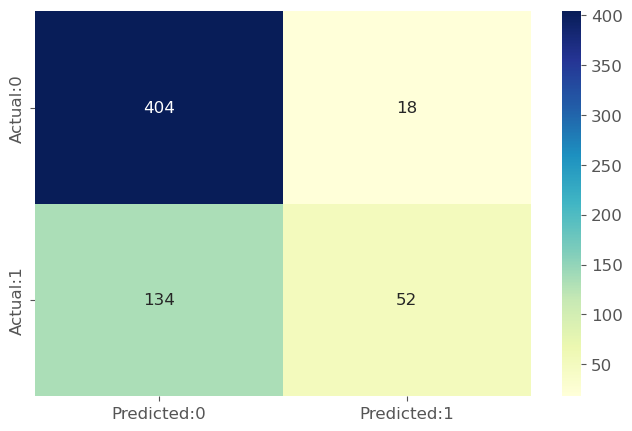

In [59]:
cm=confusion_matrix(y_test,predicciones7)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [60]:
VN = cm[1,1]
VP = cm[0,0]
FN = cm[1,0]
FP = cm[0,1] 
Exactitud = (VP+VN)/(VP+VN+FP+FN) #Acurracy
Sencibilidad = VP/float(VP+FN)
Especificidad = VN/float(VN+FP)

print(f'Exactitud :{100*Exactitud}%','\n',
f'Sencibilidad :{100*Sencibilidad}%','\n',
f'Especificidad :{100*Especificidad}%','\n') 

Exactitud :75.0% 
 Sencibilidad :75.09293680297398% 
 Especificidad :74.28571428571429% 



In [61]:
print(classification_report(y_test,  predicciones7))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       422
           1       0.74      0.28      0.41       186

    accuracy                           0.75       608
   macro avg       0.75      0.62      0.62       608
weighted avg       0.75      0.75      0.71       608



## Predicción de Probabilidad

In [62]:
# Predicción de probabilidades
# ==============================================================================
predicciones2 = stacking_cla.predict_proba(X = X_test)
df_predicciones2 = pd.DataFrame(data=predicciones2, columns=['0', '1'])
df_predicciones2['clasificacion_default_0.5'] = np.where(df_predicciones2['0'] > df_predicciones2['1'], 0, 1)
df_predicciones2.head(5)

,0,1,clasificacion_default_0.5
0,0.570538,0.429462,0
1,0.775844,0.224156,0
2,0.843408,0.156592,0
3,0.828179,0.171821,0
4,0.711559,0.288441,0


#### Modificando el umbral de probabilidad para la clasificación

In [63]:
#from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import binarize


Umbral = pd.DataFrame(np.zeros((9,4)), columns=["Umbral", "Sensibilidad", "Especificidad", "Exactitud"])
for i in range(1,10):
    cm2=0
    y_pred2 = np.where(df_predicciones2['1'] > (i/10), 1, 0)
    cm2=confusion_matrix(y_test,y_pred2)
    VN2 = cm2[1,1]
    VP2 = cm2[0,0]
    FN2 = cm2[1,0]
    FP2 = cm2[0,1] 
    Exactitud2 = (VP2+VN2)/(VP2+VN2+FP2+FN2) #Acurracy
    Sencibilidad2 = VP2/float(VP2+FN2)
    Especificidad2 = VN2/float(VN2+FP2)
    Umbral.loc[i-1,'Umbral'] = i/10
    Umbral.loc[i-1,'Sensibilidad'] = Sencibilidad2 
    Umbral.loc[i-1,'Especificidad'] = Especificidad2 
    Umbral.loc[i-1,'Exactitud'] = Exactitud2
Umbral

,Umbral,Sensibilidad,Especificidad,Exactitud
0,0.1,NaN,0.305921,0.305921
1,0.2,0.893258,0.388372,0.536184
2,0.3,0.839650,0.494340,0.689145
3,0.4,0.790287,0.587097,0.738487
4,0.5,0.750929,0.742857,0.750000
5,0.6,0.709459,0.875000,0.713816
6,0.7,0.696370,1.000000,0.697368
7,0.8,0.694079,NaN,0.694079
8,0.9,0.694079,NaN,0.694079


## Importancia de predictores
Importancia por permutación

In [64]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = stacking_cla,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
7,0.342723,0.006689,Ti2
6,0.218914,0.007136,Temp3
11,0.213283,0.007302,pH_Requisito
12,0.194628,0.006747,Tamin
10,0.190522,0.012968,PPPCF
0,0.174949,0.005008,Dia_Semana
1,0.167134,0.010255,Temp1
3,0.162971,0.004539,Temp2
4,0.160948,0.005248,Franja2
2,0.143257,0.007805,Franja1


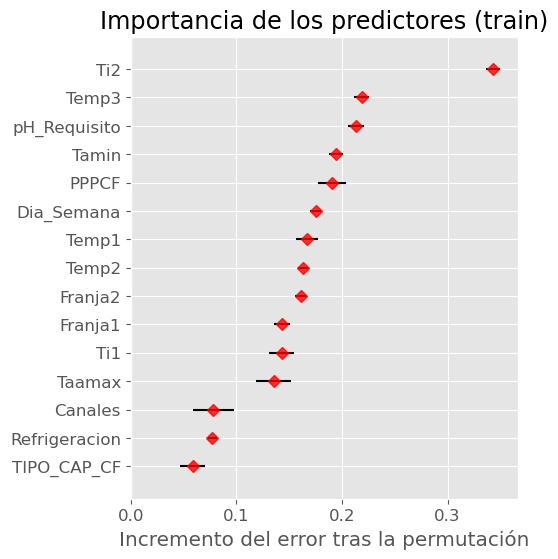

In [65]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');